In [1]:
# Import dependencies
import numpy as np
import omnipose

# set up plotting defaults
from omnipose.plot import imshow
omnipose.plot.setup()

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
from omnipose.gpu import use_gpu
use_GPU = use_gpu()

2025-01-23 19:41:05,909	[INFO]     omnipose/gpu.py               <module>....()	 line   9	On ARM, OMP_NUM_THREADS set to 1


In [2]:
# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')
%matplotlib inline

In [3]:
import cellpose_omni
from cellpose_omni import models
from cellpose_omni.models import MODEL_NAMES

MODEL_NAMES

omnipose installed


['bact_phase_omni',
 'bact_fluor_omni',
 'worm_omni',
 'worm_bact_omni',
 'worm_high_res_omni',
 'cyto2_omni',
 'plant_omni',
 'bact_phase_cp',
 'bact_fluor_cp',
 'plant_cp',
 'worm_cp',
 'cyto',
 'nuclei',
 'cyto2']

In [4]:
model_name = 'cyto2_omni'
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

pretrained_model False cyto2_omni
2025-01-23 19:41:12,053	[INFO]     cellpose_omni/models.py       __init__....()	 line 435	>>cyto2_omni<< model set to be used
2025-01-23 19:41:12,058	[INFO]     cellpose_omni/core.py         assi...evice()	 line  67	Using GPU.
2025-01-23 19:41:12,176	[INFO]                                   __init__....()	 line 163	u-net config: ([2, 32, 64, 128, 256], 4, 2)


In [5]:
from pathlib import Path

basedir = '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/omnipose'
# use rglob to search subfolders recursively 
files = [str(p) for p in Path(basedir).rglob("*.npy")] 
files

['/Users/adele/PycharmProjects/Ecoli_smFISH/tests/omnipose/grgb.npy']

In [6]:
from skimage import io

imgs = [np.load(f) for f in files]

# print some info about the images.
for i in imgs:
    print('Original image shape:',i.shape)
    print('data type:',i.dtype)
    print('data range: min {}, max {}\n'.format(i.min(),i.max()))
nimg = len(imgs)
print('\nnumber of images:',nimg)

Original image shape: (4, 2294, 2294)
data type: float64
data range: min 0.0, max 58512.0


number of images: 1


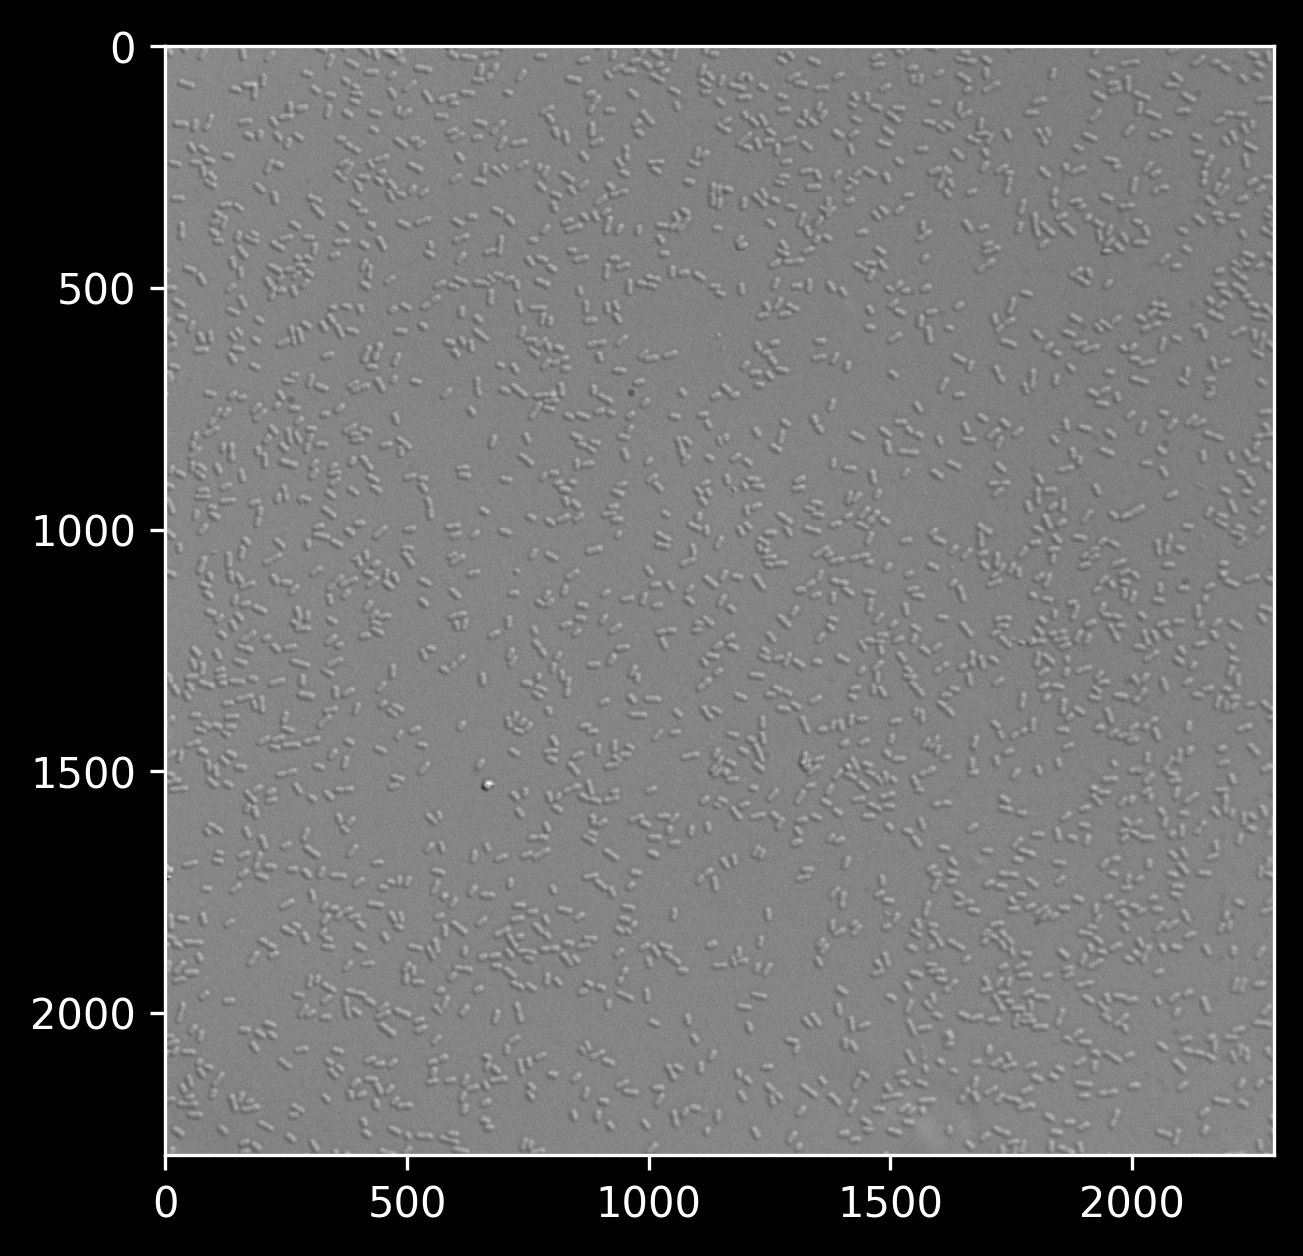

In [7]:
plt.imshow(imgs[0][1])

In [8]:
import time
chans = [1,2] #this means segment based on first channel, no second channel 

n = [-1] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
params = {'channels':chans, # always define this with the model
          'rescale': None, # upscale or downscale your images, None = no rescaling 
          'mask_threshold': 0, # erode or dilate masks with higher or lower values between -5 and 5 
          'flow_threshold': 0, # default is .4, but only needed if there are spurious masks to clean up; slows down output
          'transparency': True, # transparency in flow output
          'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
          'cluster': True, # use DBSCAN clustering
          'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
          'verbose': False, # turn on if you want to see more output 
          'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
          'niter': None, # default None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
          'augment': False, # Can optionally rotate the image and average network outputs, usually not needed 
          'affinity_seg': False, # new feature, stay tuned...
         }

tic = time.time() 
masks, flows, styles = model.eval([imgs[i] for i in n],**params)

net_time = time.time() - tic

print('total segmentation time: {}s'.format(net_time))

/Users/adele/Projects/omnipose/cellpose_omni/transforms.py:587: UserWarning: chan to seg' has value range of ZERO
  warnings.warn("chan to seg' has value range of ZERO")


total segmentation time: 5.899334907531738s


In [9]:
masks

[array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0, 21, 21, ...,  0,  0,  0],
        [21, 21, 21, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16)]

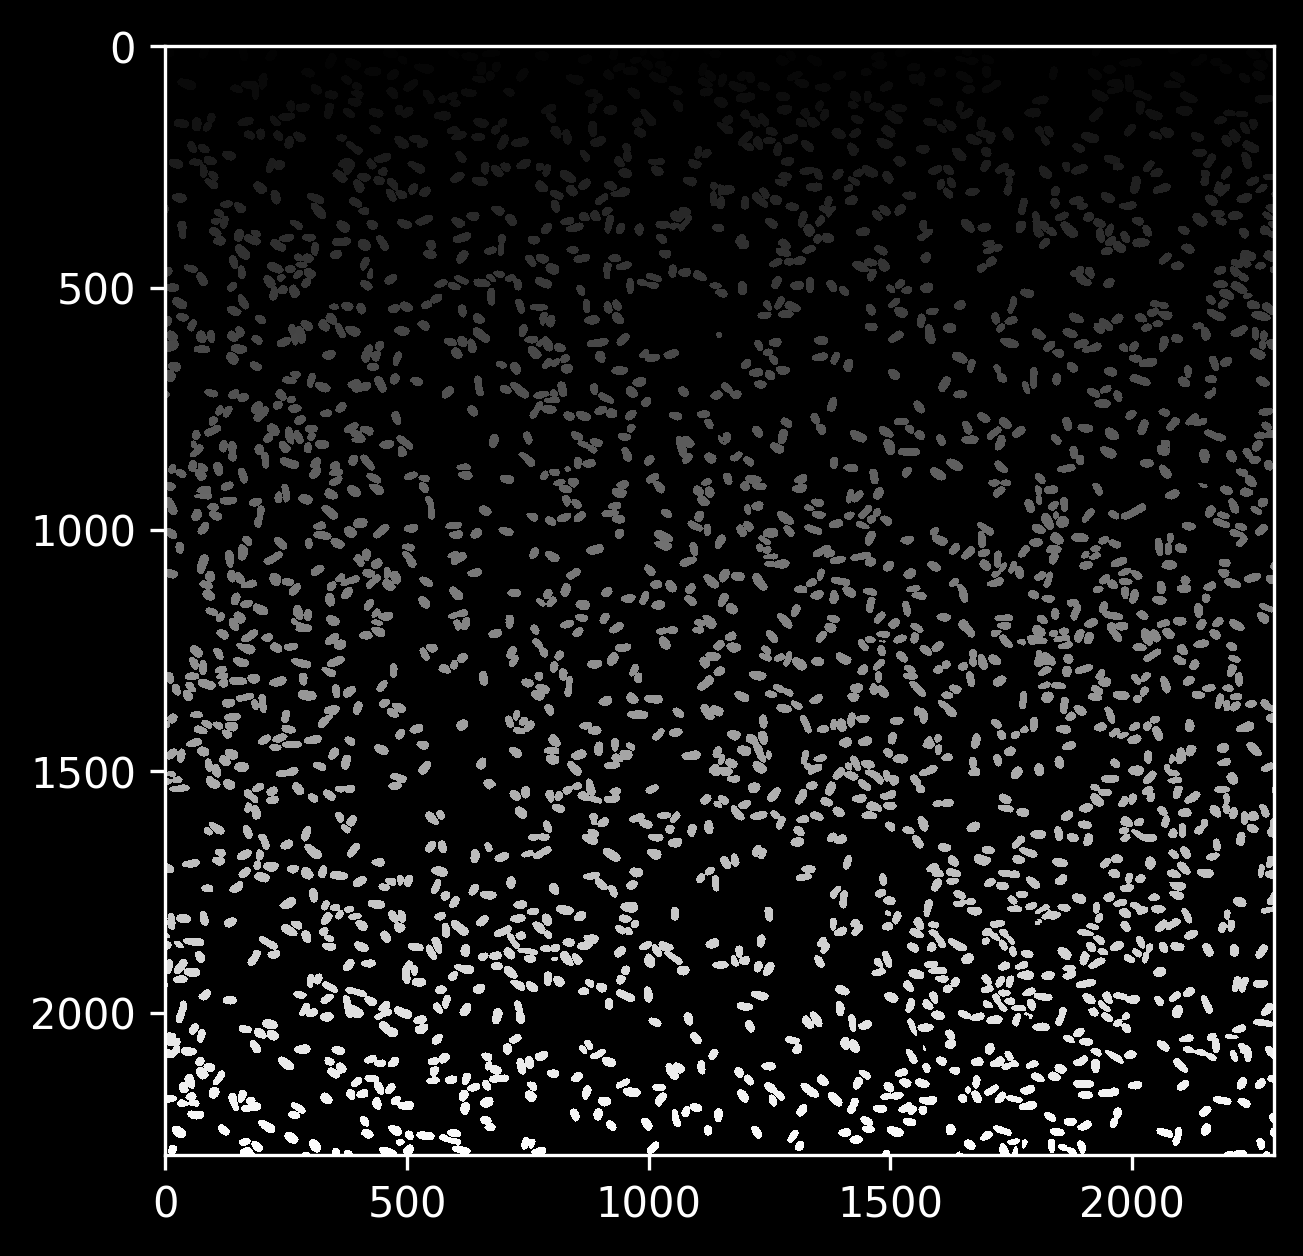

In [10]:
plt.imshow(masks[0])

In [11]:
from drawdata import ScatterWidget